In [1]:
#
# File:            z5206979_MTRN4110_PhaseC.ipynb
# Date:            16/07/2021
# Description:     Controller of E-puck for Phase C - Copmuter Vision
# Author:          Noah Correa
# Modifications: 
# Platform:        Windows
# Notes:           
#

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from math import floor

In [3]:
# Constants
MAZE_PATH = "../Maze.png"
ROBOT_PATH = "../Robot.png"
MAP_PATH = "../MapBuilt.txt"

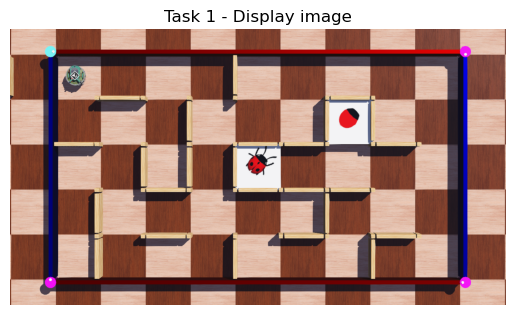

In [4]:
# Task 1
# Read in image and display it in RGB
def task1(plot=False):
    # Read in images
    maze_img = cv2.cvtColor(cv2.imread(MAZE_PATH), cv2.COLOR_BGR2RGB)
    robot_img = cv2.cvtColor(cv2.imread(ROBOT_PATH), cv2.COLOR_BGR2RGB)
    # target_img = cv2.cvtColor(cv2.imread(TARGET_PATH), cv2.COLOR_BGR2RGB)
    # marker_img = cv2.cvtColor(cv2.imread(MARKER_PATH), cv2.COLOR_BGR2RGB)

    if plot:
        # Plot image
        plt.plot(), plt.imshow(maze_img), plt.axis('off'), plt.title(f"Task 1 - Display image")
        plt.show()

    return maze_img, robot_img

maze_img, robot_img = task1(plot=True)

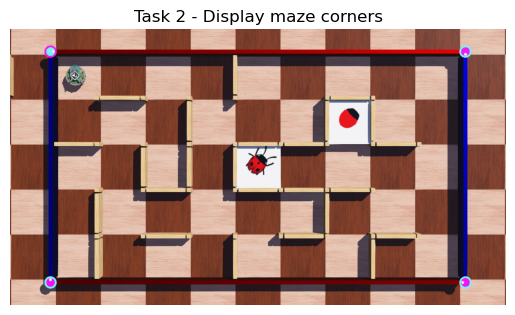

In [5]:
# Task 2
# Find the four ordered cornerstones
def task2(maze_img, plot=False):
    # Convert image to HSV colourspace
    maze_cp = np.copy(maze_img)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)

    # Set colour ranges for pink and cyan
    low_pink = (140, 215, 240)
    high_pink = (160, 255, 255)
    low_cyan = (80, 100, 240)
    high_cyan = (90, 255, 255)

    # Get masks of image for both colours
    cyan_mask = cv2.inRange(maze_hsv, low_cyan, high_cyan)
    pink_mask = cv2.inRange(maze_hsv, low_pink, high_pink)

    # Find circles in image
    cyan_circles = cv2.HoughCircles(cyan_mask, cv2.HOUGH_GRADIENT, 5, minDist=10, param1=50, param2=18, minRadius=4, maxRadius=25)
    pink_circles = cv2.HoughCircles(pink_mask, cv2.HOUGH_GRADIENT, 5, minDist=10, param1=50, param2=18, minRadius=4, maxRadius=25)

    # Define cornerstone regions
    regionA = [[0, 0], [375, 337.5]]
    regionB = [[30, 1012.5], [375, 1350]]
    regionC = [[375, 0], [750, 337.5]]
    regionD = [[375, 1012.5], [750, 1350]]

    # Find initial corners
    _, cyan_contours, _ = cv2.findContours(cyan_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _, pink_contours, _ = cv2.findContours(pink_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Fill in corners
    for c in cyan_contours:
        e = cv2.fitEllipse(c)
        cv2.ellipse(cyan_mask, e, (255, 255, 255), -1)
    for c in pink_contours:
        e = cv2.fitEllipse(c)
        cv2.ellipse(pink_mask, e, (255, 255, 255), -1)

    # Find the corners again
    _, cyan_contours, _ = cv2.findContours(cyan_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _, pink_contours, _ = cv2.findContours(pink_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the ellipse for each corner
    centers = []
    for c in cyan_contours:
        e = cv2.fitEllipse(c)
        centers.append(e[0])
        cv2.ellipse(maze_cp, e, (243, 25, 245), 3)

    for c in pink_contours:
        e = cv2.fitEllipse(c)
        centers.append(e[0])
        cv2.ellipse(maze_cp, e, (120, 243, 245), 3)

    centers = np.float32(centers)

    # # Re-order centers for perspective transform
    ordered_centers = []
    if inRegion(centers[0], regionA):
        ordered_centers = orderPoints(centers, 'A')
    else:
        ordered_centers = orderPoints(centers, 'D')
    
    if plot:
        # Plot maze with circles on cornerstones
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 2 - Display maze corners")
        plt.show()

    return maze_cp, ordered_centers

# Checks if given point lies within given region
def inRegion(point, region):
    top, left = region[0]
    bottom, right = region[1]
    x, y = point
    if top <= y <= bottom and left <= x <= right: 
        return True

    return False

# Orders the points for perspective transformation
def orderPoints(points, region):
    rect = np.zeros((4, 2), dtype = "float32")
    s = points.sum(axis = 1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]
    diff = np.diff(points, axis = 1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]
    if region is 'D':
        rect = np.array((rect[2],rect[3],rect[0],rect[1]))

    return rect

maze_corners, corners = task2(maze_img, plot=True)

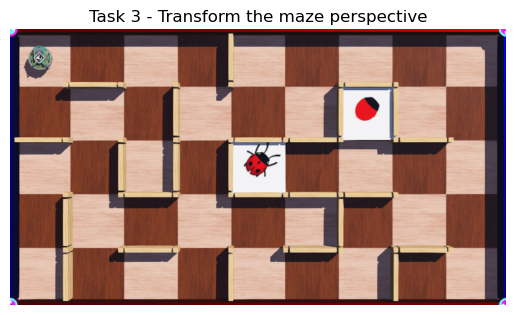

In [6]:
# Task 3
# Perspective transform the maze to a rectangle
def task3(maze_img, corners, robot_img, plot=False):
    end_corners = np.float32([[0, 0], [900, 0], [900, 500], [0, 500]])

    # Transform maze perspective
    matrix = cv2.getPerspectiveTransform(corners, end_corners)
    maze_transformed = cv2.warpPerspective(maze_img, matrix, (900, 500))

    # Transform robot perspective
    robot_transformed = cv2.warpPerspective(robot_img, matrix, (1350,750))

    # HSV threshold robot image to get only the robot
    low_robot = (17,0,90)
    high_robot = (133, 206, 185)
    robot_hsv = cv2.cvtColor(robot_transformed, cv2.COLOR_RGB2HSV)
    robot_mask = cv2.inRange(robot_hsv, low_robot, high_robot)

    # Find the bounding box for the robot
    _, contours, _ = cv2.findContours(robot_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = 0, 0, 0, 0
    for c in contours:
        cx,cy,cw,ch = cv2.boundingRect(c)
        if cw > w and ch > h:
            x, y, w, h = cx, cy, cw, ch
    
    # Crop the robot image to contain only the robot
    crop = robot_transformed[y:y+h,x:x+w]

    # Plot results
    if plot:
        plt.plot(), plt.imshow(maze_transformed), plt.axis('off'), plt.title("Task 3 - Transform the maze perspective")
        plt.show()
        
    return maze_transformed, crop


maze_transformed, robot_transformed = task3(maze_corners, corners, robot_img, plot=True)

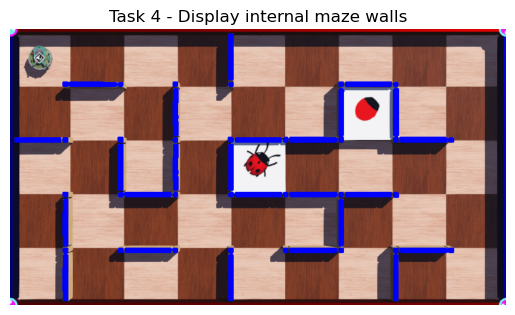

In [7]:
# Task 4
# Detect all the internal walls
def task4(maze_img, plot=False):
    maze_cp = np.copy(maze_img)
    maze_grey = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2GRAY)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)
    low_walls = (15, 30, 225)
    high_walls = (30, 130, 240)

    # HSV threshold for walls
    wall_mask = cv2.inRange(maze_hsv, low_walls, high_walls)
    wall_mask = cv2.GaussianBlur(wall_mask,(5,5),cv2.BORDER_DEFAULT)
    _, wall_mask = cv2.threshold(wall_mask,50,255,cv2.THRESH_BINARY)

    # Find and draw contours
    contours = cv2.findContours(wall_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(maze_cp, contours[1], -1, (0,0,255), thickness=-1)

    vWalls = [[" " for i in range(8)] for j in range(5)]
    hWalls = [["   " for i in range(4)] for j in range(9)]

    # Vertical walls
    for i in range(5):
        x = (100 * i + 50)
        for j in range(8):
            y = (100 * j + 100)
            roi = wall_mask[x-20:x+20, y-20:y+20]
            if np.count_nonzero(roi) >= 10:
                vWalls[i][j] = "|"

    # Horizontal walls
    for i in range(9):
        y = (100 * i + 50)
        for j in range(4):
            x = (100 * j + 100)
            roi = wall_mask[x-20:x+20, y-20:y+20]
            if np.count_nonzero(roi) >= 10:
                hWalls[i][j] = "---"

    # Plot Results
    if plot:
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 4 - Display internal maze walls")
        plt.show()
    return maze_cp, hWalls, vWalls

maze_walls, hWalls, vWalls = task4(maze_transformed, plot=True)

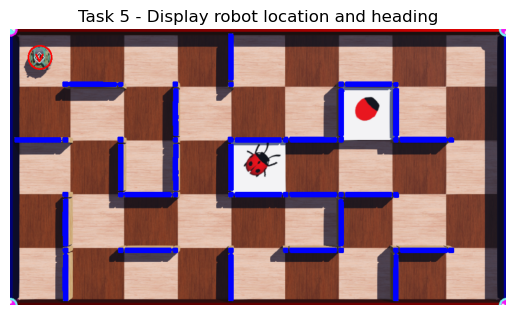

In [8]:
# Task 5
# Detect the location and heading of the robot
def task5(maze_img, robot_img, plot=False):
    # Determine robot location
    maze_cp = np.copy(maze_img)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)

    # HSV threshold the image to find robot location
    low_robot = (21,0,0)
    high_robot = (89, 255, 255)
    robot_mask = cv2.inRange(maze_hsv, low_robot, high_robot)

    # Find robot contours
    _, robot_contours, _ = cv2.findContours(robot_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find all minimum enclosing circles for all contours
    centers = []
    radii = []
    for c in robot_contours:
        center, radius = cv2.minEnclosingCircle(c)
        centers.append(center)
        radii.append(radius)

    # Find min enclosing circle with largest radius to get robot location
    robot_index = np.argmax(radii)
    robot_center = (int(centers[robot_index][0]), int(centers[robot_index][1]))
    robot_radius = int(radii[robot_index])

    # Draw circle on robot location
    cv2.circle(maze_cp, robot_center, robot_radius, (255, 0, 0), 2)


    # Determine robot orientation
    # Detect ArUco marker
    arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_50)
    arucoParams = cv2.aruco.DetectorParameters_create()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(robot_img, arucoDict, parameters=arucoParams)

    # Find the direction the top-left corner of the marker is facing
    # (Top-left corner of marker represents the forward direction of the robot)
    marker_size_x = np.abs(corners[0][0][0][0] - corners[0][0][2][0])
    marker_size_y = np.abs(corners[0][0][0][1] - corners[0][0][2][1])
    marker_size = max(marker_size_x, marker_size_y)
    x, y = corners[0][0][0]
    height, width = robot_img.shape[0:2]
    if x > width//2 + marker_size//3:
        heading = ">"
        offset_x = -12
        offset_y = 10
    elif x < width//2 - marker_size//3:
        heading = "<"
        offset_x = -11
        offset_y = 10
    elif y < height//2 - marker_size//3:
        heading = "^"
        offset_x = -11
        offset_y = 9
    else:
        heading = "v"
        offset_x = -9
        offset_y = 9
        
    # Display heading in center of robot
    text_origin = (robot_center[0] + offset_x, robot_center[1] + offset_y)
    cv2.putText(maze_cp, heading, text_origin, cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2, cv2.LINE_AA)
    
    # Transform robot location to cell notation
    rx = int(floor(robot_center[1] / 100.0))
    ry = int(floor(robot_center[0] / 100.0))
    robot_loc = [rx,ry,heading]

    # Plot the results
    if plot:
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 5 - Display robot location and heading")
        plt.show()

    return maze_cp, robot_loc

maze_robot, robot_loc = task5(maze_walls, robot_transformed, plot=True)


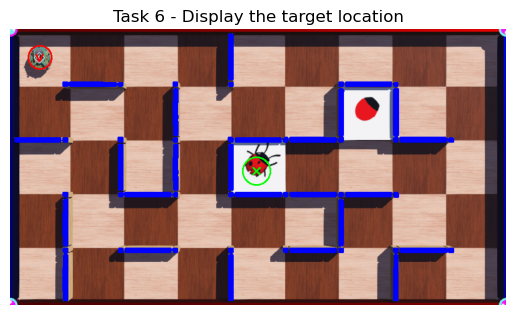

In [9]:
# Task 6
# Detect the position of the true target
def task6(maze_img, plot=False):
    maze_cp = np.copy(maze_img)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)

    target_low = (128,104,140)
    target_high = (179,226,227)
    target_mask = cv2.inRange(maze_hsv, target_low, target_high)

    # Find robot contours
    _, target_contours, _ = cv2.findContours(target_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find all minimum enclosing circles for all contours
    centers = []
    radii = []
    for c in target_contours:
        center, radius = cv2.minEnclosingCircle(c)
        centers.append(center)
        radii.append(radius)

    # Find min enclosing circle with largest radius to get robot location
    target_index = np.argmax(radii)
    target_center = (int(centers[target_index][0]), int(centers[target_index][1]))
    target_radius = 25

    # Draw target circle and marker
    cv2.circle(maze_cp, target_center, target_radius, (0, 255, 0), 2)
    text_origin = (target_center[0] - 10, target_center[1] + 8)
    cv2.putText(maze_cp, 'x', text_origin, cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0), 2, cv2.LINE_AA)

    # Transform robot location to cell notation
    tx = int(floor(target_center[1] / 100.0))
    ty = int(floor(target_center[0] / 100.0))
    target_loc = [tx,ty]

    # Plot the results
    if plot:
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 6 - Display the target location")
        plt.show()

    return maze_cp, target_loc

maze_target, target_loc = task6(maze_robot, plot=True)

In [10]:
# Task 7
# Generate a map and write it to a text file
def task7(hWalls, vWalls, robot_loc, target_loc, plot=False):
    # print(robot_loc)
    hWall = "---"
    hEmpty = "   "
    vWall = "|"
    vEmpty = " "
    robot = " " + robot_loc[2] + " "
    target = " x "

    top = [hWall for i in range(9)]
    with open(MAP_PATH, 'w+') as f:
        # Loop through each line
        for i in range(11):
            # Top or bottom lines
            if i == 0 or i == 10:
                row = vEmpty + vEmpty.join(top) + vEmpty
            # Horizontal walls
            elif i % 2 == 0:
                row = vEmpty
                for j in range(9):
                    row = row + hWalls[j][i//2-1] + vEmpty
            
            # Vertical walls
            else:
                # Check if target or robot is in current line 
                if target_loc[0] == i//2 or robot_loc[0] == i//2:
                    row = vWall
                    # Loop through each col and vertical wall
                    for j in range(0, 18):
                        # Check if j is a cell
                        if j%2 == 1:
                            # Check if target is in current cell
                            if target_loc[0] == i//2 and j//2 == target_loc[1]:
                                row = row + " x "
                            # Check if robot is in current cell
                            elif robot_loc[0] == i//2 and j//2 == robot_loc[1]:
                                row = row + " " + robot_loc[2] + " "
                            # Otherwise 
                            else:
                                row = row + hEmpty
    
                        # Check if j is not a cell
                        elif j != 0:
                            row = row + vWalls[i//2][j//2-1]
                    row = row + vWall

                # If robot or target is not on current line, print out whole line
                else:
                    row = vWall + hEmpty + hEmpty.join(vWalls[i//2]) + hEmpty + vWall
            # If not last line, add a newline
            if i != 10:
                row = row + "\n"
            # Write map to file
            f.write(row)
            if plot:
                print(row, end="")
            
    print(f"\nGenerated map to file \"{MAP_PATH}\"")            
    return

task7(hWalls, vWalls, robot_loc, target_loc, plot=True)

 --- --- --- --- --- --- --- --- --- 
| v             |                   |
     ---                 ---         
|           |           |   |       |
 ---             --- ---     ---     
|       |   |   | x                 |
         ---     --- --- ---         
|   |                   |           |
         ---         ---     ---     
|   |           |           |       |
 --- --- --- --- --- --- --- --- --- 
Generated map to file "../MapBuilt.txt"
